In [1]:
from numba import cuda

device = cuda.get_current_device(); device.reset()

In [2]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
from transformers import BertForSequenceClassification, AdamW
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import urllib.request
from tqdm import tqdm
from transformers import BertTokenizer, TFBertForSequenceClassification

In [3]:
max_seq_len = 128
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [4]:

path = "C:/Users/chan/Documents/GitHub/ML/test_NVDA/"
news_df = pd.DataFrame(columns=["title", "content"])

for txts in os.listdir(path):
    full_path = os.path.join(path, txts)  # 파일 전체 경로 생성
    if full_path.endswith('header.txt'):
        continue
    if os.path.isfile(full_path):  # 파일인지 확인
        with open(full_path, "r", encoding="utf-8") as txt_file:
            title = txt_file.readline().strip()
            content = txt_file.read().replace('\n', ' ')
            # DataFrame 생성 후 concat 함수를 사용하여 추가
            new_row = pd.DataFrame({"title": [title], "content": [content]})
            news_df = pd.concat([news_df, new_row], ignore_index=True)

news_df


,title,content
0,"Fri, 17 May 2024 19:19:00 GMT",Shares of NVIDIA Co. (NASDAQ:NVDA - Get Free ...
1,"Fri, 17 May 2024 08:19:22 GMT",Investors are always looking for stocks that ...
2,"Fri, 17 May 2024 13:26:31 GMT",Oppenheimer reissued their outperform rating ...
3,"Fri, 17 May 2024 14:25:59 GMT",Good Morning Traders! In today's Market Clubh...
4,"Fri, 17 May 2024 12:01:14 GMT",** Shares of Advanced Micro Devices AMD rise ...
5,"Fri, 17 May 2024 20:03:00 GMT",After unveiling its highly anticipated new ch...
6,"Fri, 17 May 2024 15:45:56 GMT",Nvidia (NVDA) is set to report its latest qua...
7,"Fri, 17 May 2024 15:01:50 GMT",Tech giant Nvidia (NVDA) is set to report its...
8,"Fri, 17 May 2024 18:24:08 GMT","Earlier this week, the deadline for regulator..."
9,"Fri, 17 May 2024 23:32:47 GMT",Microsoft MSFT said on Thursday it plans to o...


In [6]:
# 데이터프레임의 'title'과 'content'를 이용하여 입력 데이터 생성
inputs = [content for content in news_df['content']]

# 입력 데이터를 BERT 모델의 입력 형식에 맞게 변환
max_length = 128
input_ids = []
attention_masks = []

for content in inputs:
    encoded_dict = tokenizer.encode_plus(
                        content,                    # content
                        add_special_tokens = True,  # Add '[CLS]' and '[SEP]'
                        max_length = max_length,           # Pad & truncate all sentences
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks
                        return_tensors = 'pt',     # Return pytorch tensors
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\chan\anaconda3\envs\ng\lib\site-packages\transformers\tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [7]:
import torch

predict_model = torch.load("bert_model_loss0.34.pth", map_location=torch.device('cpu'))
predict_model.to(torch.device('cpu'))


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [8]:
predicted_labels = []

for inputs in tqdm(zip(input_ids, attention_masks)):
    input_ids = inputs[0].to(torch.device('cpu'))
    attention_mask = inputs[1].to(torch.device('cpu'))
    output = predict_model(input_ids, attention_mask=attention_mask)

    ps = F.softmax(output.logits, dim=1)
    top_p, top_class = ps.topk(1, dim=1)
    predicted_labels.append(top_class.item())

predict_df = pd.DataFrame({'predicted_label': predicted_labels})
news_df["predict"] = predict_df
news_df.to_csv('predicted_news.csv', index=False)

24it [00:05,  4.58it/s]


In [9]:
news_df

,title,content,predict
0,"Fri, 17 May 2024 19:19:00 GMT",Shares of NVIDIA Co. (NASDAQ:NVDA - Get Free ...,0
1,"Fri, 17 May 2024 08:19:22 GMT",Investors are always looking for stocks that ...,2
2,"Fri, 17 May 2024 13:26:31 GMT",Oppenheimer reissued their outperform rating ...,2
3,"Fri, 17 May 2024 14:25:59 GMT",Good Morning Traders! In today's Market Clubh...,1
4,"Fri, 17 May 2024 12:01:14 GMT",** Shares of Advanced Micro Devices AMD rise ...,2
5,"Fri, 17 May 2024 20:03:00 GMT",After unveiling its highly anticipated new ch...,0
6,"Fri, 17 May 2024 15:45:56 GMT",Nvidia (NVDA) is set to report its latest qua...,1
7,"Fri, 17 May 2024 15:01:50 GMT",Tech giant Nvidia (NVDA) is set to report its...,1
8,"Fri, 17 May 2024 18:24:08 GMT","Earlier this week, the deadline for regulator...",2
9,"Fri, 17 May 2024 23:32:47 GMT",Microsoft MSFT said on Thursday it plans to o...,2


In [10]:
news_df['date'] = pd.to_datetime(news_df['title']).dt.date  # 날짜 추출
news_df['time'] = pd.to_datetime(news_df['title']).dt.time  # 시간 추출

# 날짜별로 그룹화하고, 'predict' 열에 대한 평균을 계산
grouped_df = news_df.groupby('date').agg({
    'title': lambda x: x.tolist(),
    'content': lambda x: x.tolist(),
    'predict': lambda x: round(x.mean(), 3)  
})

grouped_df.reset_index(inplace=True)  # 인덱스 리셋

# 결과 출력
grouped_df[['date', 'title', 'content', 'predict']]

,date,title,content,predict
0,2024-05-17,"[Fri, 17 May 2024 19:19:00 GMT, Fri, 17 May 20...",[ Shares of NVIDIA Co. (NASDAQ:NVDA - Get Free...,1.261
1,2024-05-18,"[Sat, 18 May 2024 01:30:00 GMT]",[ Type a few symbols and Take a Trial. The sig...,1.000


In [11]:
result_df = grouped_df[['date', 'predict']]
result_df

,date,predict
0,2024-05-17,1.261
1,2024-05-18,1.000


In [12]:
news_df['date'] = pd.to_datetime(news_df['title']).dt.date  # 날짜 추출
news_df['time'] = pd.to_datetime(news_df['title']).dt.time  # 시간 추출

# 'date' 열을 datetime 형식으로 다시 변환
news_df['date'] = pd.to_datetime(news_df['date'])

# 날짜별로 그룹화하고, 'predict' 열에 대한 평균을 계산
grouped_df = news_df.groupby('date').agg({
    'title': lambda x: x.tolist(),
    'content': lambda x: x.tolist(),
    'predict': lambda x: round(x.mean(), 3)  
})

grouped_df.reset_index(inplace=True)  # 인덱스 리셋

# 모든 날짜를 포함하는 날짜 범위 생성
all_dates = pd.date_range(start=grouped_df['date'].min(), end=grouped_df['date'].max(), freq='D')
# 새로운 DataFrame 생성 후 기존 데이터와 병합
complete_df = pd.DataFrame(all_dates, columns=['date'])
complete_df['date'] = pd.to_datetime(complete_df['date'])  # 날짜를 datetime으로 변환
complete_df = complete_df.merge(grouped_df, on='date', how='left')
# 누락된 'predict' 값을 이전 값으로 채우기
complete_df['predict'] = complete_df['predict'].fillna(method='ffill')

# 'date'와 'predict' 열만 선택하여 결과 출력
result_df = complete_df[['date', 'predict']]
result_df.tail(10)

,date,predict
0,2024-05-17,1.261
1,2024-05-18,1.000


In [3]:

import pandas_datareader.data as web # 주식 데이터를 얻어오기 위해 사용
import datetime # 시간 처리
import matplotlib.pyplot as plt
import yfinance as yf
import FinanceDataReader as fdr
from prophet import Prophet
%matplotlib inline

C:\Users\chan\anaconda3\envs\ng\lib\site-packages\yfinance\base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [63]:
start_date = datetime.datetime( 2021, 4, 5 )
# end_date = datetime.datetime( 2024, 5, 11)
end_date = datetime.datetime( 2024, 5, 18)

# # 주어진 범위 내에 있는 날짜 생성
# missing_dates = pd.date_range(start=start_date, end=end_date).difference(result_df['date'])

# # 새로운 날짜와 예측값 추가
# for date in missing_dates:
#     result_df = result_df.append({'date': date, 'predict': 1.0}, ignore_index=True)

# 날짜 기준으로 데이터프레임 정렬
# result_df = result_df.sort_values('date').reset_index(drop=True)
# result_df

<h1>ticker data저장하는 코드</h1>

In [64]:
ticker = 'NVDA'
# result_df = result_df.iloc[:-1]
csv_filename = f"news_data_{ticker}.csv"
result_df = pd.read_csv(csv_filename)
# result_df.to_csv(csv_filename, index=False)
result_df = result_df.sort_values('date').reset_index(drop=True)
result_df['date'] = pd.to_datetime(result_df['date'])
result_df

,date,predict
0,2021-04-05,2.000
1,2021-04-06,1.000
2,2021-04-07,1.000
3,2021-04-08,1.000
4,2021-04-09,1.000
...,...,...
1134,2024-05-13,1.375
1135,2024-05-14,1.225
1136,2024-05-15,1.333
1137,2024-05-16,1.079


In [65]:
def makeStockChart(code, sDay, eDay):
    data = yf.download(code, start=sDay, end=eDay)

In [66]:
code_name = 'NVDA'
makeStockChart(code_name, start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


In [67]:
datas = yf.download(code_name, start=start_date, end=end_date)

dic = {
    'ds' : datas.index,
    'y' : datas.Close,
    # 'volume': datas.Volume
    
}

finance_df = pd.DataFrame( dic )

#인덱스 초기화(원본 까지 적용)
finance_df.reset_index( inplace=True )

del finance_df['Date']

finance_df.head(5)
finance_df.tail(5)
finance_df

[*********************100%%**********************]  1 of 1 completed


,ds,y
0,2021-04-05,139.875000
1,2021-04-06,138.615005
2,2021-04-07,141.434998
3,2021-04-08,143.169998
4,2021-04-09,144.000000
...,...,...
782,2024-05-13,903.989990
783,2024-05-14,913.559998
784,2024-05-15,946.299988
785,2024-05-16,943.590027


<br>1. 당장 열리는 트레이딩에 맞게 첫번째 추천은 종가와 ds를 하나 추가해 만든채로 예측</br>
2. 10시30분 종가를 활용하여 첫추천 </br> 
3. 그 다음은 1시간뒤 추천 

In [68]:

# stock = yf.Ticker("AVGO")
# hist = stock.history(period = '1d',interval="1h")
# last_row = finance_df.iloc[-1]  # 마지막 행 가져오기
# next_date = last_row['ds'] + pd.DateOffset(days=1)
# second_price = hist['Close'][1]# 1 -> 10시반 / 3 -> 12시반 / 5 -> 2시반 / 6 -> 3시반
# start_next_row = pd.DataFrame({'ds': [next_date], 'y': second_price })
# finance_df = pd.concat([finance_df, start_next_row], ignore_index=True)  # 기존 데이터프레임에 추가
# finance_df

In [69]:
date_range = pd.date_range(start=start_date, end=end_date)
df_date_range = pd.DataFrame(date_range, columns=['date'])
df_filtered = df_date_range[~df_date_range['date'].isin(finance_df['ds'])]
df_filtered

,date
5,2021-04-10
6,2021-04-11
12,2021-04-17
13,2021-04-18
19,2021-04-24
...,...
1125,2024-05-04
1126,2024-05-05
1132,2024-05-11
1133,2024-05-12


In [70]:
common_dates = result_df[result_df['date'].isin(df_filtered['date'])]['date']
result_filtered = result_df[~result_df['date'].isin(common_dates)]
result_filtered

,date,predict
0,2021-04-05,2.000
1,2021-04-06,1.000
2,2021-04-07,1.000
3,2021-04-08,1.000
4,2021-04-09,1.000
...,...,...
1134,2024-05-13,1.375
1135,2024-05-14,1.225
1136,2024-05-15,1.333
1137,2024-05-16,1.079


In [71]:
result_filtered.reset_index(inplace=True)
result_filtered

,index,date,predict
0,0,2021-04-05,2.000
1,1,2021-04-06,1.000
2,2,2021-04-07,1.000
3,3,2021-04-08,1.000
4,4,2021-04-09,1.000
...,...,...,...
782,1134,2024-05-13,1.375
783,1135,2024-05-14,1.225
784,1136,2024-05-15,1.333
785,1137,2024-05-16,1.079


In [72]:
result_filtered_future = result_filtered.copy()
result_filtered_future = result_filtered_future.drop(columns=['index'])
result_filtered_future



,date,predict
0,2021-04-05,2.000
1,2021-04-06,1.000
2,2021-04-07,1.000
3,2021-04-08,1.000
4,2021-04-09,1.000
...,...,...
782,2024-05-13,1.375
783,2024-05-14,1.225
784,2024-05-15,1.333
785,2024-05-16,1.079


In [73]:
# 'predict' 열에만 평균 값 추가
mean_last_seven = result_filtered_future['predict'].iloc[-7:].mean()
# mean_last_seven_1 = result_filtered_future['volume'].iloc[-7:].mean()
# 다음 날짜 계산
last_date = result_filtered_future['date'].iloc[-1]
next_date = pd.to_datetime(last_date) + pd.DateOffset(days=1)

# 데이터프레임에 새로운 행 추가
new_row = {'date': next_date, 'predict': round(mean_last_seven, 3)}  # 소수점 세 자리까지 반올림
result_filtered_future = result_filtered_future.append(new_row, ignore_index=True)

# 'predict' 열의 소수점 자리 수 설정
result_filtered_future['predict'] = result_filtered_future['predict'].round(3)

result_filtered_future


C:\Users\chan\AppData\Local\Temp\ipykernel_17404\3564898628.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_filtered_future = result_filtered_future.append(new_row, ignore_index=True)


,date,predict
0,2021-04-05,2.000
1,2021-04-06,1.000
2,2021-04-07,1.000
3,2021-04-08,1.000
4,2021-04-09,1.000
...,...,...
783,2024-05-14,1.225
784,2024-05-15,1.333
785,2024-05-16,1.079
786,2024-05-17,1.261


In [74]:
finance_df = pd.concat([finance_df, result_filtered['predict']], axis=1)
finance_df

,ds,y,predict
0,2021-04-05,139.875000,2.000
1,2021-04-06,138.615005,1.000
2,2021-04-07,141.434998,1.000
3,2021-04-08,143.169998,1.000
4,2021-04-09,144.000000,1.000
...,...,...,...
782,2024-05-13,903.989990,1.375
783,2024-05-14,913.559998,1.225
784,2024-05-15,946.299988,1.333
785,2024-05-16,943.590027,1.079


In [59]:
# file_path = "finance_df.csv"
# finance_df.to_csv(file_path, index=False)

In [46]:
# import logging
# logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

# # Day 단위로 데이터가 구성되어 있으므로, 일 단위 주기성 활성화
# # model = Prophet(changepoint_prior_scale=0.31150996767072153,
# #                 changepoint_range=0.8409742702125196, 
# #                 daily_seasonality=True,
# #                 holidays_prior_scale=0.5429118795932729, 
# #                 seasonality_mode='multiplicative',
# #                 seasonality_prior_scale=1.2964727674363865,
# #                 weekly_seasonality=True,
# #                 n_changepoints=25,
# #                 growth='linear',
# #                 yearly_seasonality=True)
# # model = Prophet(changepoint_prior_scale=0.3225469441035442,
# #                 changepoint_range=0.8959729377163332, 
# #                 daily_seasonality=True,
# #                 holidays_prior_scale=0.48141493972833566, 
# #                 seasonality_mode='multiplicative',
# #                 seasonality_prior_scale=0.27212358941114123,
# #                 weekly_seasonality=False,
# #                 n_changepoints=24,
# #                 growth='linear',
# #                 yearly_seasonality=True) # cross_validation(m, initial='250 days', period='10 days', horizon='1 days')
# model = Prophet(changepoint_prior_scale=0.1541135741310533,
#                 changepoint_range=0.7075492829641814, 
#                 daily_seasonality=False,
#                 holidays_prior_scale=0.5080563204252423, 
#                 seasonality_mode='multiplicative',
#                 seasonality_prior_scale=4.043977713268082,
#                 weekly_seasonality=True,
#                 n_changepoints=25,
#                 growth='linear',
#                 yearly_seasonality=True) #cross_validation(m, initial='250 days', period='20 days', horizon='1 days')
                
# model.add_country_holidays(country_name='US')
# model.add_regressor('predict')
# # 데이터 학습 시작 -> 기계학습
# model.fit( finance_df )
# # print(model.params['beta'])
# # 주가 예측 위한 날짜 데이터 세팅 -> 기존 데이터 + 향후 10일치 예측값

# future = model.make_future_dataframe( periods = 1)
# future['predict'] = result_filtered_future['predict'].values
# # 주가 예측
# forecast = model.predict( future )

# # forecast.columns ->
# '''
#   Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
#        'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
#        'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
#        'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper',
#        'multiplicative_terms', 'multiplicative_terms_lower',
#        'multiplicative_terms_upper', 'yhat'],
#       dtype='object')
# ''' 

# # 모델 예측 결과 출력
# print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(11))

# # 모델 예측 그래프 출력
# fig = model.plot(forecast)

# plt.show(fig)


01:31:22 - cmdstanpy - INFO - Chain [1] start processing
01:31:23 - cmdstanpy - INFO - Chain [1] done processing


            ds        yhat  yhat_lower  yhat_upper
777 2024-05-06  879.373590  860.311318  896.366152
778 2024-05-07  877.273618  858.445260  894.271478
779 2024-05-08  891.788646  873.300269  909.506799
780 2024-05-09  893.634962  876.184338  910.830907
781 2024-05-10  903.064557  885.593176  922.100823
782 2024-05-13  919.795402  901.684571  939.123556
783 2024-05-14  923.572445  905.164386  941.667562
784 2024-05-15  931.247095  913.980834  948.724820
785 2024-05-16  934.278570  916.365137  950.963896
786 2024-05-17  943.815444  926.196756  961.549316
787 2024-05-18  950.848639  933.583366  969.128282


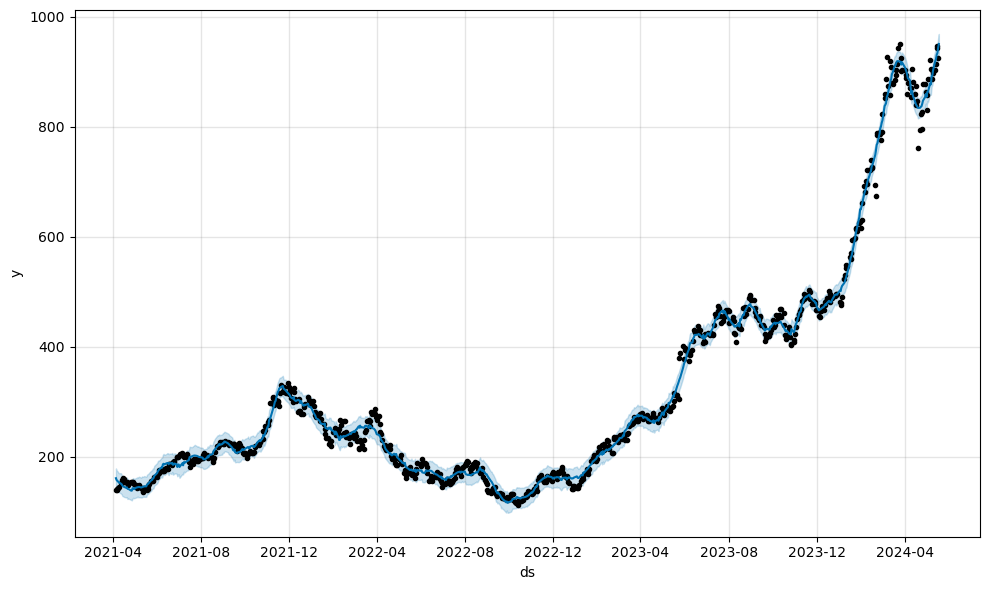

In [75]:
# 저장된 모델 파라미터를 파일로 저장

import pickle   
    # # 저장된 모델 파라미터를 불러오는 함수
    # ticker = ticker
    # start_date = start_date
    # end_date_1 = end_date_1 
    # finance_df,result_filtered_future = bertcode(ticker,start_date,end_date_1)
def load_prophet_model_parameters(file_path):
    with open(file_path, 'rb') as f:
        model_params = pickle.load(f)
    return model_params
    
file_path = f"prophet_model_parameters_NVDA.pkl"
loaded_model_parameters = load_prophet_model_parameters(file_path)

# Prophet 모델 생성 및 파라미터 설정
loaded_model = Prophet(
    changepoint_prior_scale=loaded_model_parameters['changepoint_prior_scale'],
    seasonality_prior_scale=loaded_model_parameters['seasonality_prior_scale'],
    holidays_prior_scale=loaded_model_parameters['holidays_prior_scale'],
    seasonality_mode=loaded_model_parameters['seasonality_mode'],
    changepoint_range=loaded_model_parameters['changepoint_range'],
    yearly_seasonality=loaded_model_parameters['yearly_seasonality'],
    weekly_seasonality=loaded_model_parameters['weekly_seasonality'],
    daily_seasonality=loaded_model_parameters['daily_seasonality'],
    growth=loaded_model_parameters['growth'],
    n_changepoints=loaded_model_parameters['n_changepoints']
)
loaded_model.add_country_holidays(country_name='US')

loaded_model.add_regressor('predict')

# 데이터 학습
loaded_model.fit(finance_df)
future = loaded_model.make_future_dataframe( periods = 1)
future['predict'] = result_filtered_future['predict'].values
# 주가 예측
forecast = loaded_model.predict(future)

# return finance_df, forecast 

# forecast.columns ->
'''
Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
   'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
   'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
   'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper',
   'multiplicative_terms', 'multiplicative_terms_lower',
   'multiplicative_terms_upper', 'yhat'],
  dtype='object')
''' 

# 모델 예측 결과 출력
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(11))

# 모델 예측 그래프 출력
fig = loaded_model.plot(forecast)

plt.show(fig)


In [61]:
import pandas as pd

# 초기 자본 설정
initial_capital = 100000000.0


# def trading():
# 사용자로부터 시작일과 종료일 입력 받기
start_date = '2024-04-05'
end_date_1 = '2024-05-17'
end_date_2 = '2024-05-18'

# 입력된 날짜 범위로 데이터 필터링
filtered_df = finance_df[(finance_df['ds'] >= start_date) & (finance_df['ds'] <= end_date_1)]
filtered_df_forcast = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date_2)]
# 현재 자본 및 보유 주식 수 초기화
current_capital = initial_capital
shares_owned = 0

# 현재 포지션 초기화
position = 'None'

# 실제 및 예측 주식 가격 설정
actual_prices = filtered_df.set_index('ds')['y']
predicted_prices = filtered_df_forcast.set_index('ds')['yhat']

# 시뮬레이션 시작
for date, today_price, predicted_next_day_price in zip(actual_prices.index, actual_prices.values, predicted_prices.shift(-1).values):
    predicted_change = predicted_next_day_price - today_price

    # 매수 조건
    if predicted_change > 0 and position != 'Hold':
        shares_to_buy = current_capital / today_price
        shares_owned += shares_to_buy
        current_capital -= shares_to_buy * today_price
        position = 'Hold'
        print(f"{date} - 매수: ${today_price:.3f} (예측 다음날 가격: ${predicted_next_day_price:.3f})")

    # 매도 조건
    elif predicted_change < 0 and position == 'Hold':
        current_capital += shares_owned * today_price
        shares_owned = 0
        position = 'None'
        print(f"{date} - 매도: ${today_price:.3f} (예측 다음날 가격: ${predicted_next_day_price:.3f})")

    # 보유 조건
    elif position == 'Hold' and abs(predicted_change) <= 0.01 * today_price:
        print(f"{date} - 보유: ${today_price:.3f}")
    else:
        # 조치 없음 또는 보유
        if position == 'Hold':
            print(f"{date} - 보유: 현재 가격 ${today_price:.3f}, 예측 다음날 가격 ${predicted_next_day_price:.3f}")
        else:
            print(f"{date} - 조치 없음: 현재 가격 ${today_price:.3f}, 예측 다음날 가격 ${predicted_next_day_price:.3f}")

# 최종 자본 및 수익률 계산
final_capital = current_capital + (shares_owned * actual_prices.iloc[-1])
profit = final_capital - initial_capital
return_rate = (profit / initial_capital) * 100

# 결과 출력
print(f"초기 자본: ${initial_capital:.3f}")
print(f"최종 자본: ${final_capital:.3f}")
print(f"수익: ${profit:.3f}")
print(f"수익률: {return_rate:.3f}%")


2024-04-05 00:00:00 - 매수: $169.580 (예측 다음날 가격: $170.541)
2024-04-08 00:00:00 - 보유: 현재 가격 $168.450, 예측 다음날 가격 $170.213
2024-04-09 00:00:00 - 보유: 현재 가격 $169.670, 예측 다음날 가격 $171.927
2024-04-10 00:00:00 - 보유: 현재 가격 $167.780, 예측 다음날 가격 $171.858
2024-04-11 00:00:00 - 매도: $175.040 (예측 다음날 가격: $171.193)
2024-04-12 00:00:00 - 조치 없음: 현재 가격 $176.550, 예측 다음날 가격 $171.658
2024-04-15 00:00:00 - 조치 없음: 현재 가격 $172.690, 예측 다음날 가격 $171.996
2024-04-16 00:00:00 - 매수: $169.380 (예측 다음날 가격: $172.273)
2024-04-17 00:00:00 - 보유: 현재 가격 $168.000, 예측 다음날 가격 $172.348
2024-04-18 00:00:00 - 보유: 현재 가격 $167.040, 예측 다음날 가격 $172.433
2024-04-19 00:00:00 - 보유: 현재 가격 $165.000, 예측 다음날 가격 $174.839
2024-04-22 00:00:00 - 보유: 현재 가격 $165.840, 예측 다음날 가격 $173.883
2024-04-23 00:00:00 - 보유: 현재 가격 $166.900, 예측 다음날 가격 $174.118
2024-04-24 00:00:00 - 보유: 현재 가격 $169.020, 예측 다음날 가격 $175.474
2024-04-25 00:00:00 - 보유: 현재 가격 $169.890, 예측 다음날 가격 $175.484
2024-04-26 00:00:00 - 보유: 현재 가격 $169.300, 예측 다음날 가격 $176.976
2024-04-29 00:00:00 - 보유: 현재 가

In [27]:
start_date = '2024-04-05'
end_date_1 = '2024-05-15'
end_date_2 = '2024-05-16'

In [74]:
filtered_df = finance_df[(finance_df['ds'] >= start_date) & (finance_df['ds'] <= end_date_1)]
filtered_df_forecast = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date_2)]

# 현재 자본 및 보유 주식 수 초기화
current_capital = initial_capital
shares_owned = 0

# 현재 포지션 초기화
position = 'None'

# 실제 및 예측 주식 가격 설정
actual_prices = filtered_df.set_index('ds')['y']
predicted_prices = filtered_df_forecast.set_index('ds')['yhat']

# 거래 기록 초기화
trading_history = []

# 시뮬레이션 시작
for date, today_price, predicted_next_day_price in zip(actual_prices.index, actual_prices.values, predicted_prices.shift(-1).values):
    predicted_change = predicted_next_day_price - today_price

    # 매수 조건
    if predicted_change > 0 and position != 'Hold':
        shares_to_buy = current_capital / today_price
        shares_owned += shares_to_buy
        current_capital -= shares_to_buy * today_price
        position = 'Hold'
        trading_history.append('Buy')

    # 매도 조건
    elif predicted_change < 0 and position == 'Hold':
        current_capital += shares_owned * today_price
        shares_owned = 0
        position = 'None'
        trading_history.append('Sell')

    # 보유 조건
    elif position == 'Hold' and abs(predicted_change) <= 0.01 * today_price:
        trading_history.append('Hold')

    # 조치 없음 또는 보유
    else:
        if position == 'Hold':
            trading_history.append('Hold')
        else:
            trading_history.append('Stay')#조치없음

# 최종 자본 및 수익률 계산

# trading_history의 마지막 인덱스 반환
last_record = trading_history[-1]
last_record

'Stay'

2024-04-05 00:00:00 - 매수: $880.080 (예측 다음날 가격: $884.802)
2024-04-08 00:00:00 - 매도: $871.330 (예측 다음날 가격: $870.627)
2024-04-09 00:00:00 - 매수: $853.540 (예측 다음날 가격: $860.634)
2024-04-10 00:00:00 - 매도: $870.390 (예측 다음날 가격: $865.431)
2024-04-11 00:00:00 - 조치 없음: 현재 가격 $906.160, 예측 다음날 가격 $856.955
2024-04-12 00:00:00 - 조치 없음: 현재 가격 $881.860, 예측 다음날 가격 $846.404
2024-04-15 00:00:00 - 조치 없음: 현재 가격 $860.010, 예측 다음날 가격 $841.857
2024-04-16 00:00:00 - 조치 없음: 현재 가격 $874.150, 예측 다음날 가격 $839.295
2024-04-17 00:00:00 - 조치 없음: 현재 가격 $840.350, 예측 다음날 가격 $837.388
2024-04-18 00:00:00 - 조치 없음: 현재 가격 $846.710, 예측 다음날 가격 $834.560
2024-04-19 00:00:00 - 매수: $762.000 (예측 다음날 가격: $834.744)
2024-04-22 00:00:00 - 보유: 현재 가격 $795.180, 예측 다음날 가격 $836.443
2024-04-23 00:00:00 - 보유: 현재 가격 $824.230, 예측 다음날 가격 $837.667
2024-04-24 00:00:00 - 보유: 현재 가격 $796.770, 예측 다음날 가격 $841.971
2024-04-25 00:00:00 - 보유: 현재 가격 $826.320, 예측 다음날 가격 $847.710
2024-04-26 00:00:00 - 매도: $877.350 (예측 다음날 가격: $854.366)
2024-04-29 00:00:00 - 조치 없음: 현

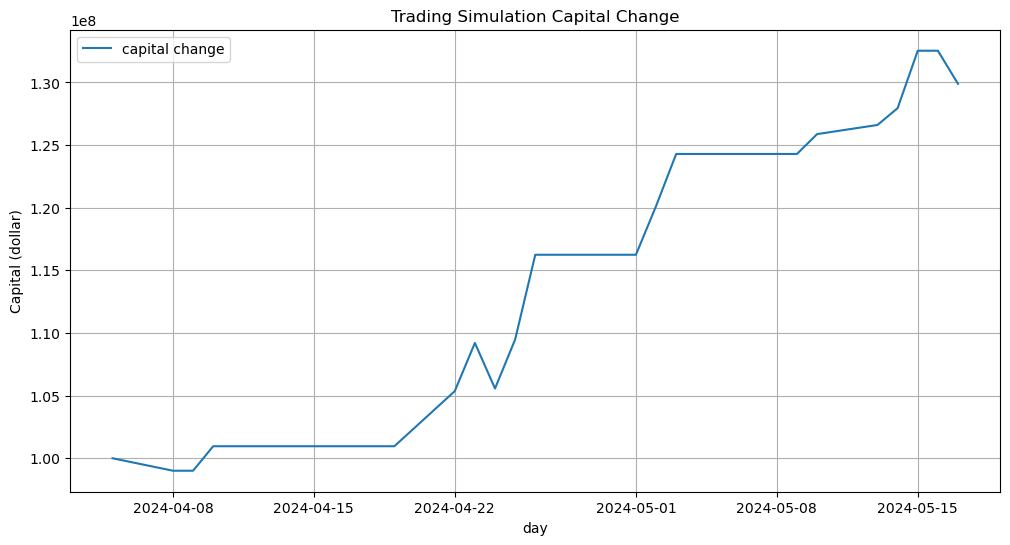

In [76]:
import pandas as pd
import matplotlib.pyplot as plt

# 초기 자본 설정
initial_capital = 100000000.0

# 사용자로부터 시작일과 종료일 입력 받기
start_date = '2024-04-05'
end_date_1 = '2024-05-17'
end_date_2 = '2024-05-18'

# 데이터 필터링
filtered_df = finance_df[(finance_df['ds'] >= start_date) & (finance_df['ds'] <= end_date_1)]
filtered_df_forcast = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date_2)]

# 현재 자본 및 보유 주식 수 초기화
current_capital = initial_capital
shares_owned = 0

# 현재 포지션 초기화
position = 'None'

# 실제 및 예측 주식 가격 설정
actual_prices = filtered_df.set_index('ds')['y']
predicted_prices = filtered_df_forcast.set_index('ds')['yhat']

# 자본 변화를 기록할 리스트 초기화
capital_history = []

# 시뮬레이션 시작
for date, today_price, predicted_next_day_price in zip(actual_prices.index, actual_prices.values, predicted_prices.shift(-1).values):
    predicted_change = predicted_next_day_price - today_price

    # 매수 조건
    if predicted_change > 0 and position != 'Hold':
        shares_to_buy = current_capital / today_price
        shares_owned += shares_to_buy
        current_capital -= shares_to_buy * today_price
        position = 'Hold'
        print(f"{date} - 매수: ${today_price:.3f} (예측 다음날 가격: ${predicted_next_day_price:.3f})")

    # 매도 조건
    elif predicted_change < 0 and position == 'Hold':
        current_capital += shares_owned * today_price
        shares_owned = 0
        position = 'None'
        print(f"{date} - 매도: ${today_price:.3f} (예측 다음날 가격: ${predicted_next_day_price:.3f})")

    # 보유 조건
    elif position == 'Hold' and abs(predicted_change) <= 0.01 * today_price:
        print(f"{date} - 보유: ${today_price:.3f}")
    else:
        if position == 'Hold':
            print(f"{date} - 보유: 현재 가격 ${today_price:.3f}, 예측 다음날 가격 ${predicted_next_day_price:.3f}")
        else:
            print(f"{date} - 조치 없음: 현재 가격 ${today_price:.3f}, 예측 다음날 가격 ${predicted_next_day_price:.3f}")

    # 현재 자본 기록
    current_total_capital = current_capital + (shares_owned * today_price)
    capital_history.append(current_total_capital)

# 최종 자본 및 수익률 계산
final_capital = current_capital + (shares_owned * actual_prices.iloc[-1]) # 현재남은돈 + (보유중인 주식갯수 * 실제 주식 가격(17일기준))
profit = final_capital - initial_capital 
return_rate = (profit / initial_capital) * 100

# 결과 출력
print(f"초기 자본: ${initial_capital:.3f}")
print(f"최종 자본: ${final_capital:.3f}")
print(f"수익: ${profit:.3f}")
print(f"수익률: {return_rate:.3f}%")

# 자본 변화 시각화
plt.figure(figsize=(12, 6))
plt.plot(actual_prices.index, capital_history, label='capital change')
plt.xlabel('day')
plt.ylabel('Capital (dollar)')
plt.title('Trading Simulation Capital Change')
plt.legend()
plt.grid(True)
plt.show()
